###Install Library

In [1]:
!pip install -q torch
!pip install -q tf
!pip install -q gdown
!pip install -q "transformers[torch]" accelerate -U
!pip install -q -U accelerate
!pip install -q datasets
!pip install -q gensim
!pip install -q tensorflow
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00


### Import Library

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from collections import Counter
import tensorflow as tf
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, TrainingArguments, EarlyStoppingCallback
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Flatten, concatenate, BatchNormalization,LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from evaluate import load as load_metric
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE,KMeansSMOTE,SVMSMOTE

###Read Dataset and load Word2Vec

In [3]:
df = pd.read_csv("/content/pilpres_train_balanced_clean.csv")

In [4]:
df_test1 = pd.read_csv("/content/pilpres_test_clean.csv")

In [5]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gc.collect()
print(gensim.__version__)
# Load Pretrained Word Embeddings (Word2Vec)
# !gdown --id 1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
# !gdown --id 1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
# !gdown --id 1VUjxpH10baOw439V-YAAVVbtyI8iLgG5

4.4.0


In [6]:
import os
import gdown
import zipfile

'''https://drive.google.com/file/d/1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3/view?usp=sharing'''

file_id = '1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3'

url = f'https://drive.google.com/uc?id={file_id}'
output_zip = 'model_w2v.zip'

if not os.path.exists('idwiki_word2vec_768_new_lower.model'):
    print("Downloading Model...")
    gdown.download(url, output_zip, quiet=False)

    print("Extracting File...")
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Done.")
else:
    print("Model Available")


Downloading...
From (original): https://drive.google.com/uc?id=1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3
From (redirected): https://drive.google.com/uc?id=1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3&confirm=t&uuid=79c26617-e733-44d2-a387-72555e5e81cf
To: /content/model_w2v.zip
100%|██████████| 2.56G/2.56G [00:24<00:00, 102MB/s] 


Extracting File...
Done.


In [7]:
word_embeddings = Word2Vec.load('/content/idwiki_word2vec_768_new_lower.model')

###Split Dataset

In [8]:
x_train = df['Text']
y_train = df['Label']

In [9]:
x_test1 = df_test1['Text']
y_test1 = np.array(df_test1['Label'])

###Define Loss Function, Tokenization, Word Embeddings and Oversampling

In [10]:
# # Define the margin loss function
# def margin_loss(y_true, y_pred):
#     margin = K.constant(0.1)
#     y_true_float = K.cast(y_true, dtype='float32')  # Convert y_true to float32
#     squared_difference_pos = K.square(K.maximum(0.9 - y_pred, 0))
#     squared_difference_neg = K.square(K.maximum(y_pred - 0.1, 0))
#     loss_pos = K.mean(y_true_float * squared_difference_pos)
#     loss_neg = K.mean((1 - y_true_float) * squared_difference_neg)
#     total_loss = loss_pos + lambda_val * loss_neg
#     return total_loss

In [11]:
# Define the model architectures
#embedding_dim = 300
#max_sequence_length = 100
# lambda_val = 0.7  # Lambda value for margin loss
#num_words = 100000
max_sequence_length = 100 # Moving the definition of max_sequence_length here

In [12]:
# Create word index
word_index = {word: index + 1 for index, word in enumerate(word_embeddings.wv.index_to_key)}

# Create embedding matrix
embedding_dim = word_embeddings.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word_embeddings.wv:
        embedding_vector = word_embeddings.wv[word]
        embedding_matrix[i] = embedding_vector


In [13]:
# Tokenization
tokenizer = Tokenizer(num_words=len(word_index) + 1, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train.astype(str))

# Convert text to sequences and pad
x_train_sequences = tokenizer.texts_to_sequences(x_train.astype(str))
# Convert all values in x_test1 to string before tokenization
x_test_sequences1 = tokenizer.texts_to_sequences(x_test1.astype(str))

# Determine max sequence length based on your data
max_sequence_length = max(max(len(seq) for seq in x_train_sequences), max(len(seq) for seq in x_test_sequences1))

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length, padding='post')
x_test_padded1 = pad_sequences(x_test_sequences1, maxlen=max_sequence_length, padding='post')

In [14]:
x_train_flat = x_train_padded.reshape(x_train_padded.shape[0], -1)

####Oversampling with BorderlineSMOTE

In [15]:
borderline_smote = BorderlineSMOTE(random_state=42)
x_train_resampled_flat_borderline, y_train_resampled_borderline = borderline_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_borderline = x_train_resampled_flat_borderline.reshape(x_train_resampled_flat_borderline.shape[0], max_sequence_length)

####Oversampling with KMeansSMOTE

In [16]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_train_resampled_flat_kmeans, y_train_resampled_kmeans = kmeans_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_kmeans = x_train_resampled_flat_kmeans.reshape(x_train_resampled_flat_kmeans.shape[0], max_sequence_length)

####Oversampling with SVMSMOTE

In [17]:
svm_smote = SVMSMOTE(random_state=42)
x_train_resampled_flat_svm, y_train_resampled_svm = svm_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_svm = x_train_resampled_flat_svm.reshape(x_train_resampled_flat_svm.shape[0], max_sequence_length)

In [18]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


##LSTM Model

In [20]:
# Define the architecture of the static model with he_normal initialization
lstm_input = Input(shape=(max_sequence_length,))
lstm_embedding = Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length, trainable=False)(lstm_input)  # Removed weights parameter

# LSTM Layers
static_lstm_output = LSTM(128, kernel_initializer=he_normal())(lstm_embedding)  # Use he_normal initialization
static_lstm_output = Dropout(0.5)(static_lstm_output)
batch_norm_layer = BatchNormalization()(static_lstm_output)

# Fully Connected Layers
static_dense_output = Dense(128, activation='relu', kernel_initializer=he_normal())(batch_norm_layer)  # Use he_normal initialization
static_dense_output = Dropout(0.5)(static_dense_output)
output = Dense(1, activation='sigmoid')(static_dense_output)

# Create the static model
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


###LSTM BorderlineSMOTE Train and Test

In [21]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_borderline = lstm_model.fit(
    x_train_resampled_borderline,
    y_train_resampled_borderline,
    batch_size=32,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5013 - loss: 0.9208 - val_accuracy: 1.0000 - val_loss: 0.6600
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5211 - loss: 0.7568 - val_accuracy: 1.0000 - val_loss: 0.6614
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5177 - loss: 0.7244 - val_accuracy: 1.0000 - val_loss: 0.6454
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5231 - loss: 0.7047 - val_accuracy: 0.0000e+00 - val_loss: 0.7058
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5251 - loss: 0.7001 - val_accuracy: 0.0000e+00 - val_loss: 0.7571
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5313 - loss: 0.6933 - val_accuracy: 0.0000e+00 - val_loss: 0.7974
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5409 - loss: 0.6911 - val_accuracy: 0.0000e+00 - val_loss: 0.7208
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5449 - loss: 0.6872 - 

####Cross-Validation Train

In [22]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [23]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_borderline)
y_train_np = np.array(y_train_resampled_borderline)

In [24]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4935 - loss: 0.6975 - val_accuracy: 0.4793 - val_loss: 0.6938
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5024 - loss: 0.6948 - val_accuracy: 0.4793 - val_loss: 0.6935
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4933 - loss: 0.6955 - val_accuracy: 0.4793 - val_loss: 0.6935
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5126 - loss: 0.6931 - val_accuracy: 0.4793 - val_loss: 0.6942
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4965 - loss: 0.6943 - val_accuracy: 0.4793 - val_loss: 0.6932
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5035 - loss: 0.6940 - val_accuracy: 0.5207 - val_loss: 0.6929
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5056 - loss: 0.6938 - val_accuracy: 0.5207 - val_loss: 0.6931
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5025 - loss: 0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5005 - loss: 0.6935 - val_accuracy: 0.4777 - val_loss: 0.6947
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5050 - loss: 0.6938 - val_accuracy: 0.5223 - val_loss: 0.6922
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4760 - loss: 0.6951 - val_accuracy: 0.5223 - val_loss: 0.6931
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5021 - loss: 0.6934 - val_accuracy: 0.4777 - val_loss: 0.6933
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4982 - loss: 0.6936 - val_accuracy: 0.4825 - val_loss: 0.6932
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1996 - loss: 0.7100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2668 - loss: 0.7065
Fold 2 - Training Loss: 0.693513810634613, Training Accuracy: 0.49769747257232666
Fold 2 - Validation Loss: 0.6921910047531128, Validation Accuracy: 0.522292971611023
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              p

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5159 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6922
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4843 - loss: 0.6951 - val_accuracy: 0.4984 - val_loss: 0.6928
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5175 - loss: 0.6930 - val_accuracy: 0.5939 - val_loss: 0.6657
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5123 - loss: 0.6943 - val_accuracy: 0.5462 - val_loss: 0.6871
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5469 - loss: 0.6860 - val_accuracy: 0.6338 - val_loss: 0.6583
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6616 - loss: 0.6236 - val_accuracy: 0.6863 - val_loss: 0.6086
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7431 - loss: 0.5633 - val_accuracy: 0.7564 - val_loss: 0.6284
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8033 - loss: 0.4842 - val_accuracy: 0.7691 -

In [25]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.8836709022521972, Std Training Accuracy: 0.1942036712314724
Mean Training Loss: 0.19422018537297844, Std Training Loss: 0.2565602155225618
Mean Validation Accuracy: 0.8867750525474548, Std Validation Accuracy: 0.1846269740200012
Mean Validation Loss: 0.20392012582160532, Std Validation Loss: 0.2576599285835324


In [26]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(0.8261748211740765), 'recall': np.float64(0.8920959356422532), 'f1-score': np.float64(0.8514004462374665), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.8437058764350585), 'recall': np.float64(0.8728751082501759), 'f1-score': np.float64(0.8505960440427947), 'support': np.float64(3137.0)}}


In [27]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_borderline.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_borderline.history['loss'][epoch]
    train_accuracy = history_lstm_borderline.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_borderline.history['val_loss'][epoch]
    val_accuracy = history_lstm_borderline.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [28]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=32)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9209 - loss: 0.4714 
Static Model Evaluation Results:
Accuracy: 0.9192708134651184


In [29]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       349
           1       0.59      0.37      0.46        35

    accuracy                           0.92       384
   macro avg       0.77      0.67      0.71       384
weighted avg       0.91      0.92      0.91       384



In [30]:
torch.cuda.empty_cache()

###LSTM KMeansSMOTE Train and Test

In [31]:
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_kmeans = lstm_model.fit(
    x_train_resampled_kmeans,
    y_train_resampled_kmeans,
    batch_size=32,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9922 - loss: 0.0296 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9985 - loss: 0.0109 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9910 - loss: 0.0359 - val_accuracy: 0.9952 - val_loss: 0.0342
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9915 - loss: 0.0491 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9943 - loss: 0.0265 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9902 - loss: 0.0449 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9960 - loss: 0.0160 - val_accuracy: 0.9920 - val_loss: 0.0468
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9966 - loss: 0.0118 - val_accuracy: 1.

In [33]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [34]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_kmeans)
y_train_np = np.array(y_train_resampled_kmeans)

In [35]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9957 - loss: 0.0231 - val_accuracy: 1.0000 - val_loss: 4.1144e-04
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 4.8208e-05
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 4.3933e-05
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9977 - loss: 0.0107 - val_accuracy: 0.9968 - val_loss: 0.0063
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9977 - loss: 0.0140 - val_accuracy: 0.9984 - val_loss: 0.0037
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9981 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0014
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 7.1763e-04
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.7428e-05
Fold 1 - Training Loss: 0.0009138268069364

In [36]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.9995572626590729, Std Training Accuracy: 0.0008575322056169439
Mean Training Loss: 0.0022776150377467274, Std Training Loss: 0.004572680538487861
Mean Validation Accuracy: 0.9996812760829925, Std Validation Accuracy: 0.0006374480916424941
Mean Validation Loss: 0.0018490388367695231, Std Validation Loss: 0.0037861190278708585


In [37]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(1.0), 'recall': np.float64(0.9993451232583064), 'f1-score': np.float64(0.9996720244960067), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.9993805912189696), 'recall': np.float64(1.0), 'f1-score': np.float64(0.9996898151153817), 'support': np.float64(3137.0)}}


In [38]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_kmeans.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_kmeans.history['loss'][epoch]
    train_accuracy = history_lstm_kmeans.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_kmeans.history['val_loss'][epoch]
    val_accuracy = history_lstm_kmeans.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [39]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=32)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9372 - loss: 0.8292 
Static Model Evaluation Results:
Accuracy: 0.9348958134651184


In [40]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.95      0.99      0.96       349
           1       0.75      0.43      0.55        35

    accuracy                           0.93       384
   macro avg       0.85      0.71      0.76       384
weighted avg       0.93      0.93      0.93       384



In [41]:
torch.cuda.empty_cache()

###LSTM SVMSMOTE Train and Test

In [42]:
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_svm = lstm_model.fit(
    x_train_resampled_svm,
    y_train_resampled_svm,
    batch_size=32,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9981 - loss: 0.0080 - val_accuracy: 0.9968 - val_loss: 0.0043
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9958 - loss: 0.0247 - val_accuracy: 1.0000 - val_loss: 2.8166e-04
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9979 - loss: 0.0111 - val_accuracy: 1.0000 - val_loss: 4.9772e-04
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 1.1204e-04
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9996 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 5.1352e-05
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9996 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 2.5719e-05
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9993 - loss: 0.001

####Cross-Validation Train

In [44]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [45]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_svm)
y_train_np = np.array(y_train_resampled_svm)

In [46]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9986 - loss: 0.0083 - val_accuracy: 1.0000 - val_loss: 5.0265e-05
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9990 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 1.3993e-04
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 6.3594e-04 - val_accuracy: 1.0000 - val_loss: 2.7945e-04
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 4.1129e-05
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 5.0172e-06
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9996 - loss: 9.9329e-04 - val_accuracy: 0.9841 - val_loss: 0.3020
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9954 - loss: 0.0611 - val_accuracy: 1.0000 - val_loss: 4.9925e-04
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

In [47]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.9997697532176971, Std Training Accuracy: 0.00022474409851905086
Mean Training Loss: 0.0010818014263350051, Std Training Loss: 0.001137923264266158
Mean Validation Accuracy: 0.99984050989151, Std Validation Accuracy: 0.00047847032546997074
Mean Validation Loss: 0.0007528432452751588, Std Validation Loss: 0.002097493654872947


In [48]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(1.0), 'recall': np.float64(0.9996784565916398), 'f1-score': np.float64(0.9998389694041869), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.9996845425867509), 'recall': np.float64(1.0), 'f1-score': np.float64(0.9998420221169037), 'support': np.float64(3137.0)}}


In [49]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_svm.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_svm.history['loss'][epoch]
    train_accuracy = history_lstm_svm.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_svm.history['val_loss'][epoch]
    val_accuracy = history_lstm_svm.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [50]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=32)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9332 - loss: 1.0192 
Static Model Evaluation Results:
Accuracy: 0.9270833134651184


In [51]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       349
           1       0.67      0.40      0.50        35

    accuracy                           0.93       384
   macro avg       0.80      0.69      0.73       384
weighted avg       0.92      0.93      0.92       384



In [52]:
torch.cuda.empty_cache()

##Evaluation

In [53]:
torch.cuda.empty_cache()

In [54]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

###LSTM

####BorderlineSMOTE

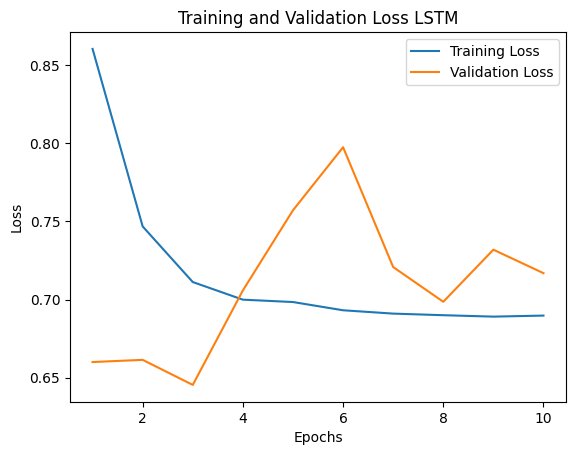

In [55]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_borderline.history['loss']
val_loss_lstm = history_lstm_borderline.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

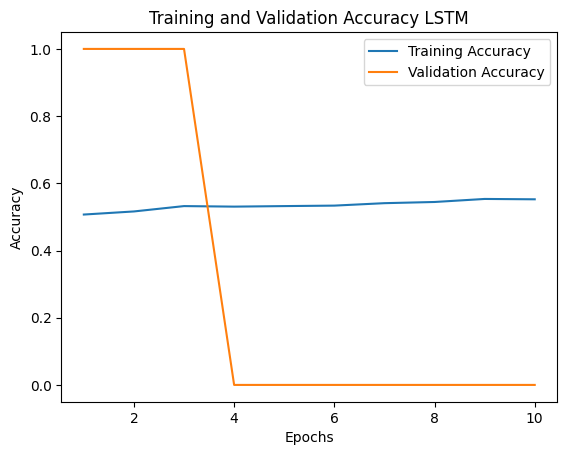

In [56]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_borderline.history['accuracy']
val_accuracy_lstm = history_lstm_borderline.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


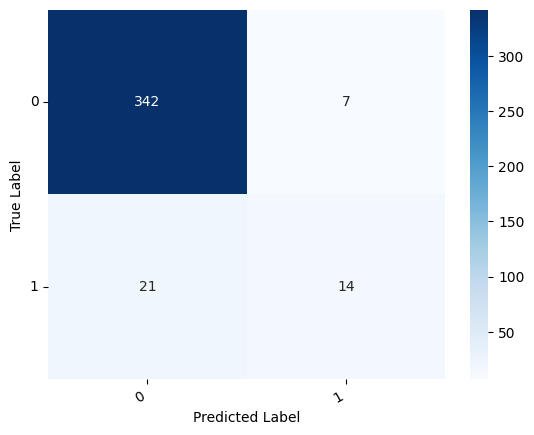

In [57]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)

####KMeansSMOTE

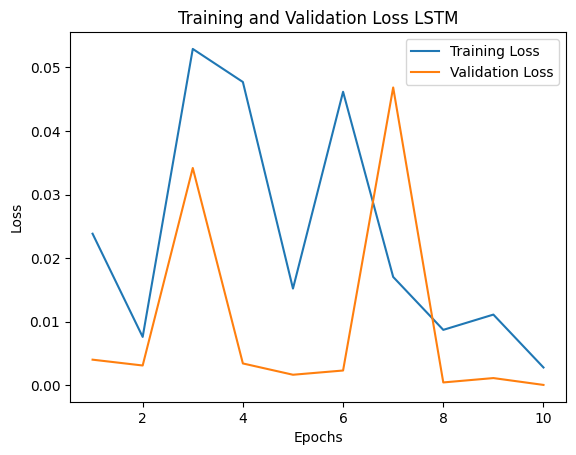

In [58]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_kmeans.history['loss']
val_loss_lstm = history_lstm_kmeans.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

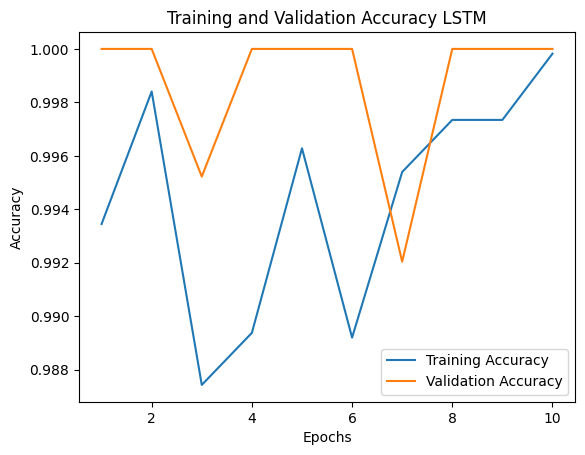

In [59]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_kmeans.history['accuracy']
val_accuracy_lstm = history_lstm_kmeans.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


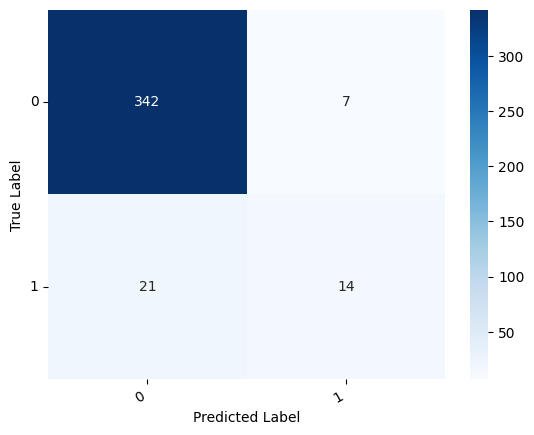

In [60]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)

####SVMSMOTE

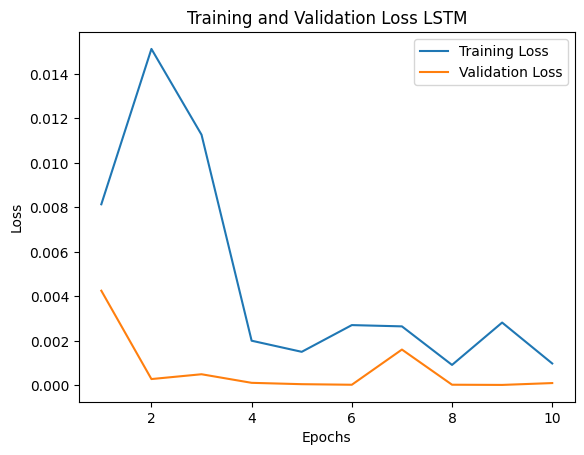

In [61]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_svm.history['loss']
val_loss_lstm = history_lstm_svm.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

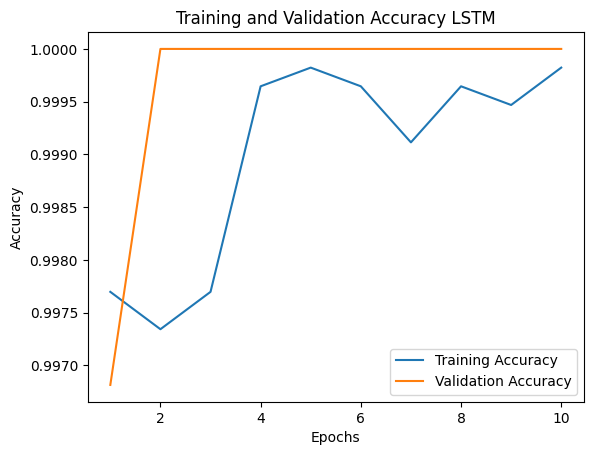

In [62]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_svm.history['accuracy']
val_accuracy_lstm = history_lstm_svm.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


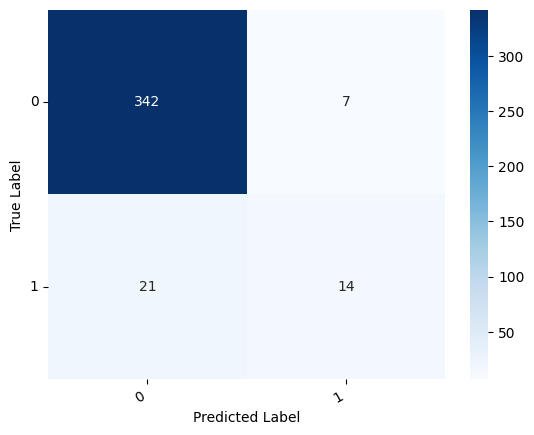

In [63]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)